In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import numpy as np
import pickle
import sys
import torch

sys.path.append("../")
from plotting_utils import custom_marginal_plot

from sbi.simulators import simulate_in_batches
from sbi.inference import prepare_for_sbi
from sbi.analysis import pairplot, conditional_pairplot
from sbi.inference import SNPE

from consbi import DATA_PATH, RESULTS_PATH

plt.style.use('../plotting_settings.mplstyle')
%matplotlib inline

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load literature inference results
with open(RESULTS_PATH.joinpath("npe_dso_gaussian_05_n500000r2x100k.p"), "rb") as fh:
    prior, estimator, posteriors, thos, xos, kwargs, seed = pickle.load(fh).values()
    
with open(DATA_PATH.joinpath("presimulated_dso_gaussian_05_n500000.p"), "rb") as fh:
    prior, ths, xs = pickle.load(fh).values()

posterior = posteriors[-1]

In [3]:
prior.covariance_matrix

tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.5000]])

## Generate predictive samples and data

In [4]:
xo = np.array([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])
posterior.set_default_x(xo)
obs_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
param_labels = [r"$\theta_{pre}$", r"$\theta_{post}$", r"$\theta_{postAll}$"]
# posterior.set_default_x(xo)

# N = 10000
# ths = prior.sample((N,))
# ndims = ths.shape[1]

In [5]:
# generate_new_results = False

# if generate_new_results:

#     thos = posterior.sample((N,), x=xo, show_progress_bars=False)
#     batch_simulator, prior = prepare_for_sbi(simulator, prior)
#     num_workers = 20
    
#     # xs = simulate_in_batches(batch_simulator, ths, num_workers=num_workers, sim_batch_size=50)
#     xos = simulate_in_batches(batch_simulator, thos, num_workers=num_workers, sim_batch_size=50)
    
#     # save posterior predictive samples
#     with open("posterior_predictive_samples.p", "wb") as fh: 
#         pickle.dump(dict(thos=thos, xos=xos), fh)
# else:
#     # load samples
#     with open("posterior_predictive_samples.p", "rb") as fh: 
#         thos, xos = pickle.load(fh).values()
        
#     with open(RESULTS_PATH.joinpath("prior_predictive_samples_dso.p"), "rb") as fh: 
#         ths, xs = pickle.load(fh).values()

In [6]:
# load cross validation results
with open(RESULTS_PATH.joinpath("cross_validation_results_default_rule.p"), "rb") as fh:
    predictive_samples_lit = pickle.load(fh)["predictive_samples_lit"]
    
# collect predicted xos for each dimension, shape 1000 x 7.
predicted_xos_per_dim = torch.stack([xii[:, ii] for ii, xii in enumerate(predictive_samples_lit)]).T.numpy()

## Figure 4 version Dec 2022
Gaussian prior with scale 0.5, contour marginals

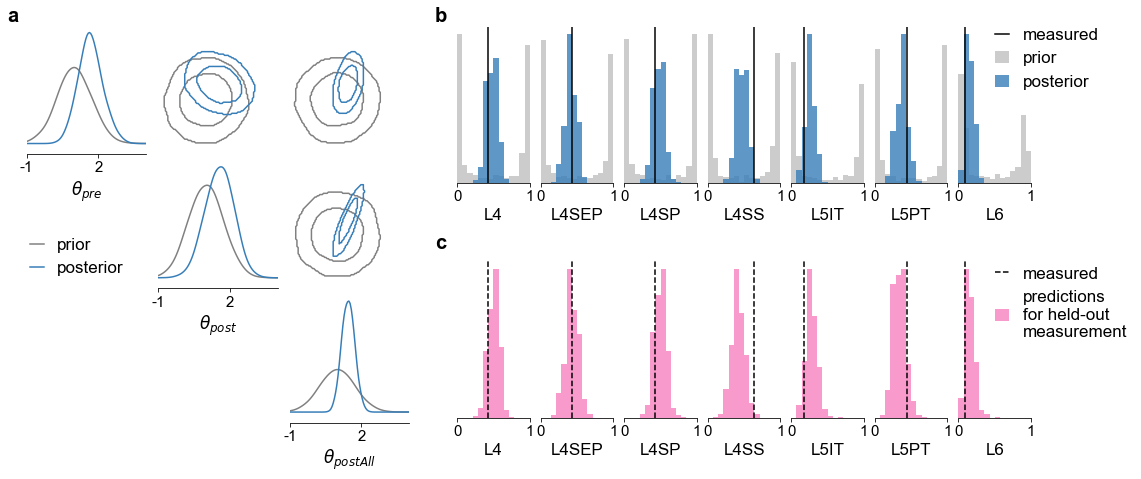

In [7]:
fig = plt.figure(figsize=(18, 7))
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0, width_ratios=[.4, .6])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3
handlelength = 0.8

# left column
left_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0.1, hspace=0.1,)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# Posteriors
posterior_opts = dict(upper="contour", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.68, 0.95]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      hist_diag=dict(bins=20, histtype="step", density=True),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 4]] * 3, 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["prior", "posterior"], 
           bbox_to_anchor=(-.1, -.6),
           handlelength=handlelength,
           loc=2)


# Posterior predictives
grid2 = outer_grid[0, 1].subgridspec(2, 1, wspace=0.0, hspace=.5)
grid21 = grid2[0, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax2 = grid21.subplots(subplot_kw=dict(sharey=True))

grid22 = grid2[1, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax3 = grid22.subplots(subplot_kw=dict(sharey=True))

# right_grid = outer_grid[0, 1].subgridspec(2, 7, wspace=0.2, hspace=0.5,)
# ax2 = right_grid.subplots(subplot_kw=dict(sharey=True, sharex=True))


bins = np.linspace(0, 1, 15)
# prior predictive
custom_marginal_plot(ax2, xs.numpy(),
                     points=xo,
                     x_label="prior", 
                     points_label="measured", 
                     show_xlabels=False,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color="gray", 
                     histtype="stepfilled",
                     alpha=0.4,
                     plot_legend=False,
                    )
custom_marginal_plot(ax2, xos.numpy(),
                     x_label="posterior", 
                     points=None,
                     points_label="measured", 
                     show_xlabels=True,
                     labels=obs_labels,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color=colors[0], 
                     plot_legend=False,)


plt.sca(ax2[-1])
bbox_to_anchor=(0.3, .5)
plt.legend(handlelength=handlelength,
           bbox_to_anchor=bbox_to_anchor, 
           loc="lower left",
          );

# Cross validation
custom_marginal_plot(ax3, predicted_xos_per_dim, xo, 
                     x_label="predictions\nfor held-out\nmeasurement", 
                     points_label="measured", 
                     labels=obs_labels,
                     num_bins=bins,
                     color=colors[3], 
                     handlelength=handlelength,
                     bbox_to_anchor=(0.28, .67), 
                     plot_legend=False,
                     points_line_style="--",
                    )

plt.sca(ax3[-1])
plt.legend(handlelength=handlelength,
           bbox_to_anchor=(0.3, .4), 
           loc="lower left",
          );

# Add Letters.
weight = "bold"
fontsize = 20
y1 = 0.91
y2 = 0.46

x1 = 0.11
x2 = 0.44
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x2, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x2, y2, "c", fontsize=fontsize, fontweight=weight);

## Posterior Analysis

In [8]:
for end in ["png", "pdf", "eps"]:
    fig.savefig(f"figure3_SBI_results_v5_with_gaussian05_contour.{end}", dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [34]:
from sbi.utils.metrics import c2st

for ii in range(7):
    print(
        c2st(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1), xos[:1000, ii].reshape(-1, 1))
    )
#     print(np.power(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1) - xos[:1000, ii].reshape(-1, 1), 2).sum())

tensor([0.5410])
tensor([0.5095])
tensor([0.5075])
tensor([0.6485])
tensor([0.5560])
tensor([0.5815])
tensor([0.5175])


In [21]:
xo

array([[0.43, 0.43, 0.42, 0.64, 0.17, 0.44, 0.09]])

In [9]:
predicted_xos_per_dim.mean(0) - xo.squeeze()

array([ 0.06890003, -0.00125998,  0.0732    , -0.22563998,  0.10932   ,
       -0.10447997,  0.07026001])

In [10]:
xos.mean(0) - xo.squeeze()

tensor([ 0.0443, -0.0129,  0.0519, -0.1744,  0.0912, -0.0721,  0.0639],
       dtype=torch.float64)

## Posterior and conditional posterior correlations

In [25]:
# posterior correlations
np.corrcoef(thos, rowvar=False)

array([[ 1.        , -0.22832248,  0.3545574 ],
       [-0.22832248,  1.        ,  0.81233571],
       [ 0.3545574 ,  0.81233571,  1.        ]])

In [26]:
from sbi.analysis import conditional_corrcoeff

conditions = posterior.sample((1000,))

cond_corr = conditional_corrcoeff(posterior, 
                                  limits=torch.tensor([[-1.0, 3.0]] * 3), 
                                  condition=conditions)
cond_corr

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[ 1.0000, -0.9899,  0.9950],
        [-0.9899,  1.0000,  0.9967],
        [ 0.9950,  0.9967,  1.0000]])

In [16]:
posterior.map() - thos.std(0) * 2, posterior.map() + thos.std(0) * 2

(tensor([0.5549, 0.3256, 0.8426]), tensor([2.5745, 2.6860, 1.9225]))

In [13]:
thos.mean(0)

tensor([1.6693, 1.5593, 1.4473])

In [12]:
posterior.map()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.5647, 1.5058, 1.3826])

In [27]:
posterior.map()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.5646, 1.5034, 1.3815])

## Figure 4 with place for 3D projection

NameError: name 'cbar' is not defined

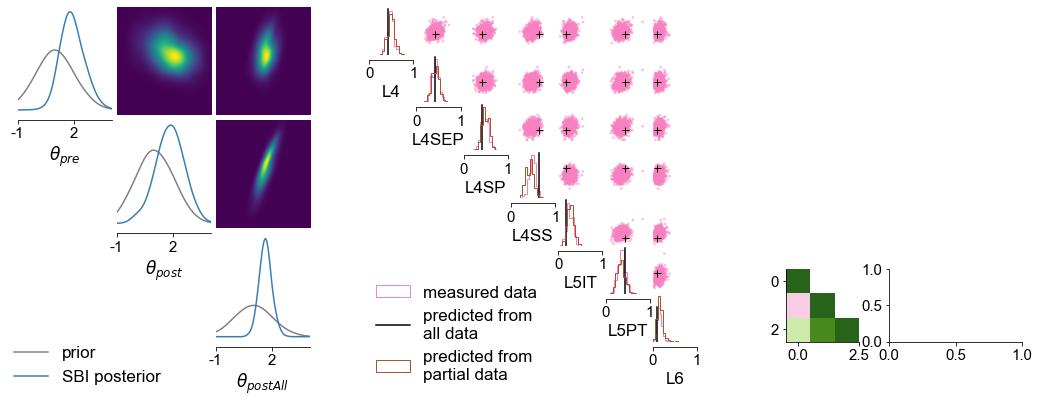

In [7]:
fig = plt.figure(figsize=(18, 6))
outer_grid = fig.add_gridspec(1, 3, wspace=0.2, hspace=0, width_ratios=[.33, .37, .3])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3

# left column
left_grid = outer_grid[0, 0].subgridspec(ndims, ndims, wspace=0.05, hspace=0.05)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# center column
num_plots = 7
center_grid = outer_grid[0, 1].subgridspec(num_plots, num_plots, wspace=0.07, hspace=0)
ax2 = center_grid.subplots()

# right column
right_grid = outer_grid[0, 2].subgridspec(2, 1, wspace=0., hspace=0.3, height_ratios=[.75, .25])

corr_subgrid = right_grid[1, 0].subgridspec(1, 2, wspace=0.0, hspace=0.0)
ax3 = corr_subgrid.subplots()

# Posteriors
posterior_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 4]] * 3, 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["prior", "SBI posterior"], 
           bbox_to_anchor=(-.2, -2.), 
           loc=2)

fig, ax2 = pairplot(xos[:1000], 
                    points=xo.squeeze(), limits=[[0, 1]]*7, 
                    labels=obs_labels, 
                    hist_diag=dict(bins=10),
                    points_offdiag=posterior_opts["points_offdiag"],
                    points_colors=["k"],
                    upper="scatter",
                    diag="hist",
                    kde_diag=dict(bins=num_bins, bw_method=bw_method),
                    scatter_offdiag=dict(s=7, alpha=0.5),
                    contour_offdiag=dict(levels=[0.99]),
                    samples_colors=[colors[3]],
                    axes=ax2, 
                    fig=fig,
                   )

# Cross validation
for idx, xis in enumerate(predictive_samples_lit):
    
    axi = ax2[idx, idx] # ax2[0 if idx<4 else 1, idx % 4]
    plt.sca(axi)
    plt.hist(xis[:, idx].reshape(1, -1), bins=10, alpha=1.0, color=colors[4], histtype="step")

plt.sca(ax2[0, 0])
plt.legend(["measured data", "predicted from \nall data", "predicted from \npartial data"], 
           bbox_to_anchor=(-.2, -4.5), 
           loc=2)

# Correlation matrices
plt.sca(ax3[0])
im = plt.imshow(correlation, clim=[-1, 1], cmap='PiYG')
# cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], )
cbar.ax.tick_params()
plt.xticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)], rotation=45)
plt.yticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)]);

plt.sca(ax3[1])
im = plt.imshow(conditional_correlation, clim=[-1, 1], cmap='PiYG')
cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], pad=0.2)
cbar.ax.tick_params()
plt.xticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)], rotation=45)
plt.yticks([0, 1, 2], []);


# Add Letters.
weight = "bold"
fontsize = 20
y = 0.91
fig.text(.09, y, "a", fontsize=fontsize, fontweight=weight)
fig.text(.37, y, "b", fontsize=fontsize, fontweight=weight)
fig.text(.66, y, "c", fontsize=fontsize, fontweight=weight)
fig.text(.66, .31, "d", fontsize=fontsize, fontweight=weight);

In [19]:
fig.savefig("figure4_SBI_results_ss50_gaussian_v2.png", dpi=300, bbox_inches='tight')

## Figure 4 version October 22

NameError: name 'samples' is not defined

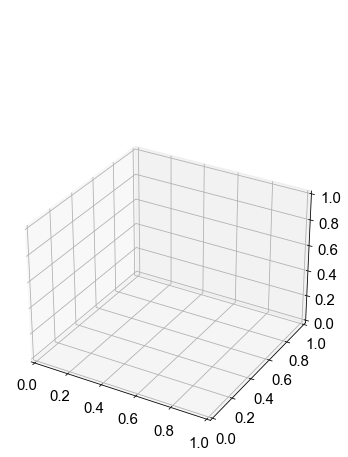

In [35]:
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0, width_ratios=[.33, .66])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3

# left column
left_grid = outer_grid[0, 0].subgridspec(2, 1, wspace=0, hspace=-0.1, height_ratios=[0.3, 0.7])
ax1 = left_grid.subplots(subplot_kw={"projection": "3d"}, )  # Create all subplots for the inner

plt.sca(ax1[0])
plt.axis("off")
ax = ax1[1]
ax.scatter(*samples.T, 
                          c=posterior.log_prob(samples), 
#             cmap="viridis",
                          alpha=0.9, s=1, label="posterior")
ax.scatter(*prior.sample((10000,)).T, 
#                           c=posterior.log_prob(osamples), 
                          c="grey",
                          alpha=0.5, s=1, label="prior")
ax.view_init(25, 13)
# from matplotlib import rcParams
rcParams['axes.labelpad'] = 0.01;
for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel(r"$\theta_{pre}$")
ax.set_ylabel(r"$\theta_{post}$")
ax.set_zlabel(r"$\theta_{postAll}$");


# right column
right_grid = outer_grid[0, 1].subgridspec(2, 1, wspace=0.07, hspace=0.35, height_ratios=[.3, .7])
upper_grid = right_grid[0, 0].subgridspec(1, 3, wspace=0.1, hspace=0)
ax2 = upper_grid.subplots()

lower_grid = right_grid[1, 0].subgridspec(2, 7, wspace=0.2, hspace=0.5)
ax3 = lower_grid.subplots(subplot_kw=dict(sharex=True, sharey=True))

# Posteriors
posterior_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax2 = marginal_plot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax2.reshape(1, 3), 
                    limits=[[-1, 4]] * 3, 
#                     ticks =[[-1, 2, 3]] * 3,
                    **posterior_opts)

plt.sca(ax2[0, -1])
plt.legend(["prior", "posterior"], 
           bbox_to_anchor=(0.7, 0.9), 
           handlelength=0.8,
           loc=2)


custom_marginal_plot(ax3[0, :], xos.numpy(), xo, 
                     x_label="inferred", 
                     points_label="measured", 
                     show_xlabels=False,
                     color=colors[3], bbox_to_anchor=(0.28, .9))

# Cross validation
# collect predicted xos for each dimension, shape 1000 x 7.
predicted_xos_per_dim = np.array([xii[:, ii] for ii, xii in enumerate(predictive_samples_lit)]).T

custom_marginal_plot(ax3[1, :], predicted_xos_per_dim, xo, 
                     x_label="predicted", 
                     points_label="measured", 
                     color=colors[4], bbox_to_anchor=(0.28, .87))

# plt.sca(ax3[1, -1])
# plt.legend(["measured data", "predicted from \nall data", "predicted from \npartial data"], 
#            bbox_to_anchor=(-.2, -4.5), 
#            loc=2)

# # Correlation matrices
# plt.sca(ax3[0])
# im = plt.imshow(correlation, clim=[-1, 1], cmap='PiYG')
# # cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], )
# cbar.ax.tick_params()
# plt.xticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)], rotation=45)
# plt.yticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)]);

# plt.sca(ax3[1])
# im = plt.imshow(conditional_correlation, clim=[-1, 1], cmap='PiYG')
# cbar = plt.colorbar(im, ticks=[-1, 0.0, 1], pad=0.2)
# cbar.ax.tick_params()
# plt.xticks([0, 1, 2], [rf"{param_labels[i]}" for i in range(3)], rotation=45)
# plt.yticks([0, 1, 2], []);


# Add Letters.
weight = "bold"
fontsize = 20
y1 = 0.91
y2 = 0.6
y3 = 0.32
x1 = 0.1
x2 = 0.38
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x2, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x1, y2, "c", fontsize=fontsize, fontweight=weight)
fig.text(x2, y2, "d", fontsize=fontsize, fontweight=weight)
fig.text(x2, y3, "e", fontsize=fontsize, fontweight=weight);

In [191]:
fig.savefig("figure4_SBI_results_v3.png", dpi=300, bbox_inches='tight')
fig.savefig("figure4_SBI_results_v3.pdf", dpi=300, bbox_inches='tight')

## Version 3 

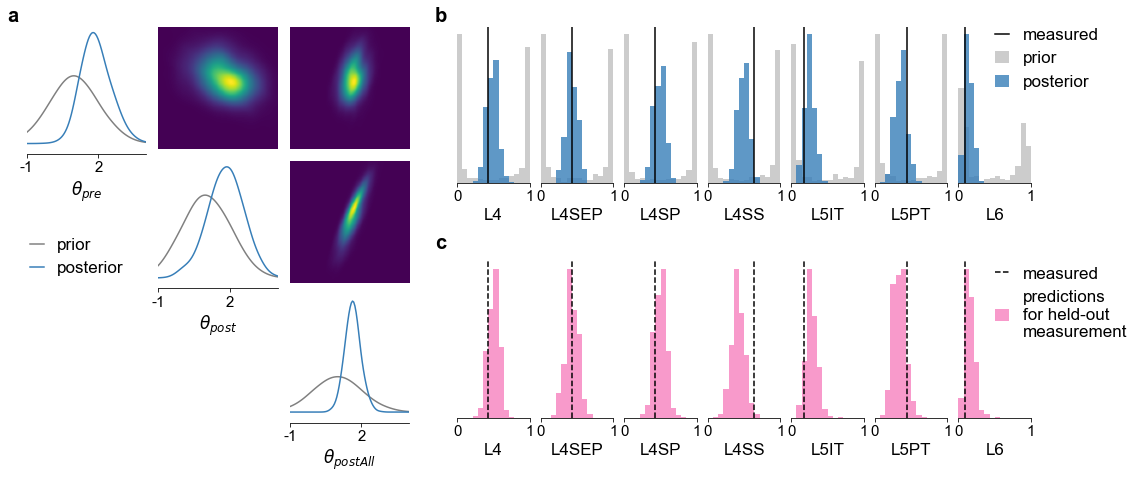

In [15]:
fig = plt.figure(figsize=(18, 7))
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0, width_ratios=[.4, .6])
num_samples = 10000
# set KDE values
num_bins = 100
bw_method = 0.3
handlelength = 0.8

# left column
left_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0.1, hspace=0.1,)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# Posteriors
posterior_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
                    samples_colors=["gray", colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 4]] * 3, 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["prior", "posterior"], 
           bbox_to_anchor=(-.1, -.6),
           handlelength=handlelength,
           loc=2)


# Posterior predictives
grid2 = outer_grid[0, 1].subgridspec(2, 1, wspace=0.0, hspace=.5)
grid21 = grid2[0, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax2 = grid21.subplots(subplot_kw=dict(sharey=True))

grid22 = grid2[1, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax3 = grid22.subplots(subplot_kw=dict(sharey=True))

# right_grid = outer_grid[0, 1].subgridspec(2, 7, wspace=0.2, hspace=0.5,)
# ax2 = right_grid.subplots(subplot_kw=dict(sharey=True, sharex=True))


bins = np.linspace(0, 1, 15)
# prior predictive
custom_marginal_plot(ax2, xs.numpy(),
                     points=xo,
                     x_label="prior", 
                     points_label="measured", 
                     show_xlabels=False,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color="gray", 
                     histtype="stepfilled",
                     alpha=0.4,
                     plot_legend=False,
                    )
custom_marginal_plot(ax2, xos.numpy(),
                     x_label="posterior", 
                     points=None,
                     points_label="measured", 
                     show_xlabels=True,
                     labels=obs_labels,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color=colors[0], 
                     plot_legend=False,)


plt.sca(ax2[-1])
bbox_to_anchor=(0.3, .5)
plt.legend(handlelength=handlelength,
           bbox_to_anchor=bbox_to_anchor, 
           loc="lower left",
          );

# Cross validation
custom_marginal_plot(ax3, predicted_xos_per_dim, xo, 
                     x_label="predictions\nfor held-out\nmeasurement", 
                     points_label="measured", 
                     labels=obs_labels,
                     num_bins=bins,
                     color=colors[3], 
                     handlelength=handlelength,
                     bbox_to_anchor=(0.28, .67), 
                     plot_legend=False,
                     points_line_style="--",
                    )

plt.sca(ax3[-1])
plt.legend(handlelength=handlelength,
           bbox_to_anchor=(0.3, .4), 
           loc="lower left",
          );

# Add Letters.
weight = "bold"
fontsize = 20
y1 = 0.91
y2 = 0.46

x1 = 0.11
x2 = 0.44
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x2, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x2, y2, "c", fontsize=fontsize, fontweight=weight);

In [16]:
fig.savefig("figure3_SBI_results_v4_with_prior.png", dpi=300, bbox_inches='tight')
fig.savefig("figure3_SBI_results_v4_with_prior.pdf", dpi=300, bbox_inches='tight')
# fig.savefig("figure3_SBI_results_v4_with_prior.eps", dpi=300, bbox_inches='tight')

In [18]:
predicted_xos_per_dim.shape

(1000, 7)

In [19]:
xos.shape

torch.Size([10000, 7])

In [34]:
from sbi.utils.metrics import c2st

for ii in range(7):
    print(
        c2st(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1), xos[:1000, ii].reshape(-1, 1))
    )
#     print(np.power(torch.tensor(predicted_xos_per_dim)[:, ii].reshape(-1, 1) - xos[:1000, ii].reshape(-1, 1), 2).sum())

tensor([0.5410])
tensor([0.5095])
tensor([0.5075])
tensor([0.6485])
tensor([0.5560])
tensor([0.5815])
tensor([0.5175])


In [58]:
xo

tensor([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])

In [62]:
predicted_xos_per_dim.mean(0) - xo.squeeze().numpy()

array([ 0.06890002, -0.00125998,  0.07320002, -0.22563997,  0.10932   ,
       -0.10447997,  0.07026   ], dtype=float32)

In [63]:
xos.mean(0) - xo.squeeze().numpy()

tensor([ 0.0541, -0.0036,  0.0581, -0.1593,  0.0871, -0.0808,  0.0570])

## Posterior and conditional posterior correlations

In [29]:
# posterior correlations
np.corrcoef(thos, rowvar=False)

array([[ 1.        , -0.3079026 ,  0.29040986],
       [-0.3079026 ,  1.        ,  0.81795337],
       [ 0.29040986,  0.81795337,  1.        ]])

In [31]:
from sbi.analysis import conditional_corrcoeff

conditions = posterior.sample((1000,))

cond_corr = conditional_corrcoeff(posterior, 
                                  limits=torch.tensor([[-1.0, 4.0]] * 3), 
                                  condition=conditions)
cond_corr

tensor([[ 1.0000, -0.9947,  0.9966],
        [-0.9947,  1.0000,  0.9975],
        [ 0.9966,  0.9975,  1.0000]])

## Bits and pieces

## Posterior projection in 3D

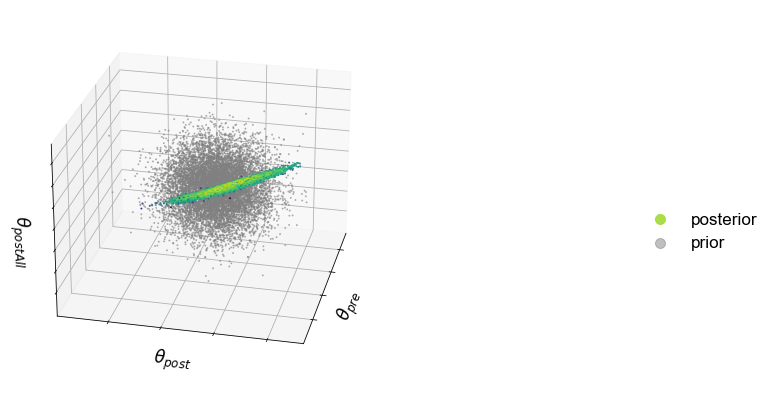

In [24]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(10, 7))

samples = posterior.sample((10000,), x=xo, show_progress_bars=False)

ax.scatter(*samples.T, 
                          c=posterior.log_prob(samples), 
#             cmap="viridis",
                          alpha=0.9, s=1, label="posterior")
ax.scatter(*prior.sample((10000,)).T, 
#                           c=posterior.log_prob(osamples), 
                          c="grey",
                          alpha=0.5, s=1, label="prior")
plt.legend(bbox_to_anchor=(2.0, 0.5), markerscale=10.0)
ax.view_init(25, 13)
# from matplotlib import rcParams
rcParams['axes.labelpad'] = 0.01;
for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel(r"$\theta_{pre}$")
ax.set_ylabel(r"$\theta_{post}$")
ax.set_zlabel(r"$\theta_{postAll}$");
fig.savefig("figure3_posterior3d.png", dpi=300, bbox_inches='tight')

In [11]:
posterior.map(x=xo, show_progress_bars=False)

tensor([1.6201, 2.0726, 1.6501])

In [12]:
thos.mean(0)

tensor([1.9134, 1.8199, 1.6404])

In [66]:
# sem
thos.std(0) / np.sqrt(thos.shape[0])

tensor([0.0063, 0.0075, 0.0033])

In [121]:
thos.var(0)

tensor([0.3955, 0.5585, 0.1074])

In [127]:
thos.std(0)**2

tensor([0.3955, 0.5585, 0.1074])

In [131]:
idx = torch.argsort(thos, dim=0)[:, 1]

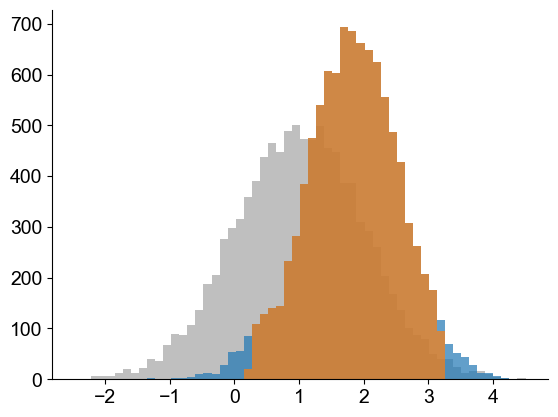

In [149]:
_, bins, _ = plt.hist(ths[:, 1].numpy(), color="gray", alpha=0.5, bins="auto")
plt.hist(thos[idx, 1].numpy(), bins=bins, alpha=0.7);
ttt = thos[idx, 1][250:-250]
plt.hist(ttt.numpy(), bins=bins, alpha=0.7);

In [142]:
ttt.min(), ttt.max()

(tensor(0.2425), tensor(3.2425))

In [14]:
posterior.set_default_x(xo)

DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3])),
               x_shape=torch.Size([1, 7]))
               

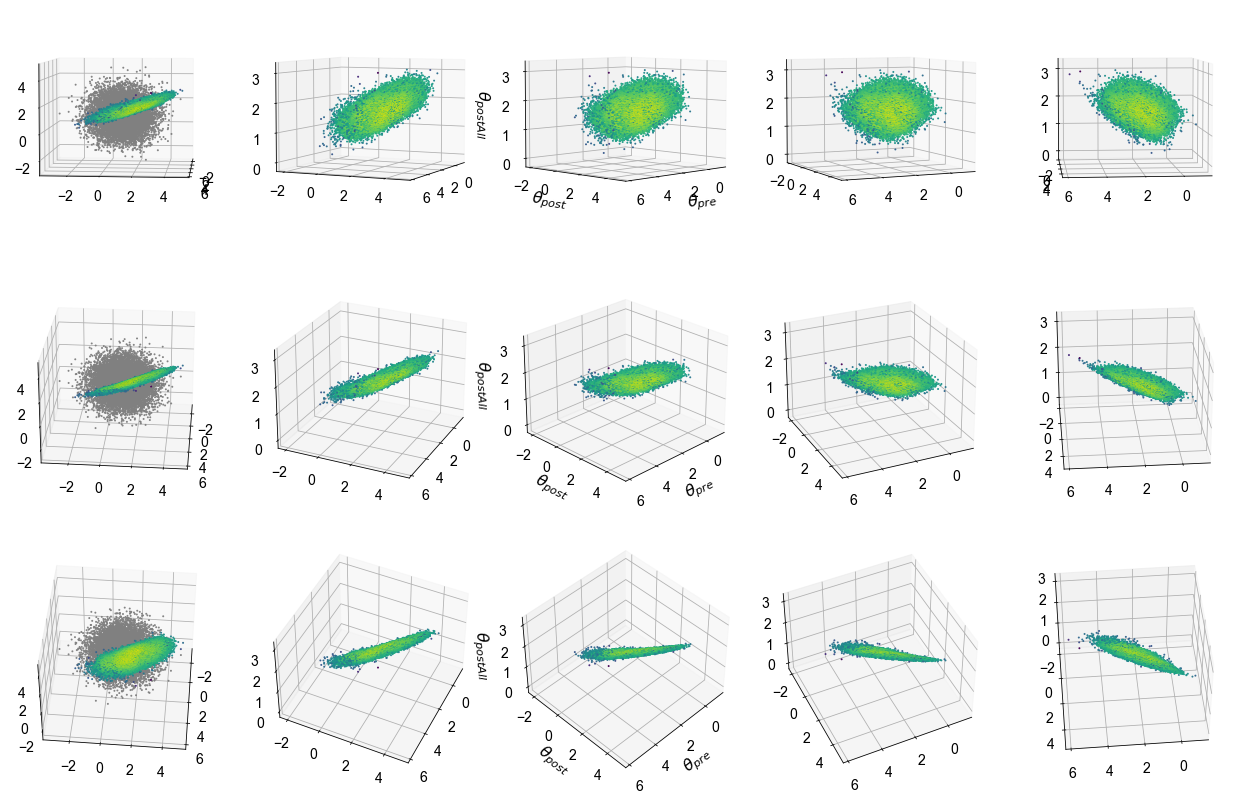

In [16]:
num_plots = 5
fig, axs = plt.subplots(3, num_plots, subplot_kw={"projection": "3d"}, figsize=(18, 12))

samples = prior.sample((10000,))
osamples = posterior.sample((100000,), show_progress_bars=False)
for j, ang in enumerate([5, 25, 45]):
    for i, angx in enumerate(np.arange(5, 100, 20)):
        ax = axs[j, i]
        if i == 0:
            surf = ax.scatter(samples[:, 0], samples[:, 1],samples[:, 2], 
#                               c=prior.log_prob(samples),
                              c="grey",
                              alpha=0.9, s=1, )
        surf = ax.scatter(osamples[:, 0], osamples[:, 1], osamples[:, 2], 
                          c=posterior.log_prob(osamples), 
#                           c="C1",
                          alpha=0.9, s=1)
        if i == 2:
            ax.set_xlabel(r"$\theta_{pre}$")
            ax.set_ylabel(r"$\theta_{post}$")
            ax.set_zlabel(r"$\theta_{postAll}$")
        ax.view_init(ang, angx)
plt.tight_layout();

In [56]:
import torch
from sbi.inference import simulate_for_sbi

def simulator(theta):
    return torch.rand_like(theta) + theta

prior = torch.distributions.MultivariateNormal(torch.zeros(3), torch.eye(3))

torch.manual_seed(42)

theta, x = simulate_for_sbi(simulator, prior, 10, show_progress_bar=False, num_workers=2)
x

tensor([[ 2.6672e+00,  2.1928e+00,  1.3827e+00],
        [-1.7818e+00,  9.2897e-01, -8.8302e-01],
        [ 8.4375e-01, -1.0948e+00, -5.2491e-01],
        [ 2.0271e+00, -9.1434e-04, -8.2179e-01],
        [ 2.7084e-01,  2.5977e-01, -1.6097e+00],
        [ 5.5515e-01, -9.9673e-01, -7.2108e-01],
        [-4.8050e-02,  2.6113e+00,  9.1649e-01],
        [-1.3940e-01, -4.8028e-01,  1.0554e+00],
        [-1.2607e+00,  1.0439e+00, -1.7137e-01],
        [-1.3112e-02, -1.1091e+00,  2.5133e+00]])